In [1]:
library(readxl)
library(dplyr)
library(caTools)
library(mltools)
library(MASS)
library(leaps)
library(glmnet)
library(ISLR)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loaded glmnet 3.0-1


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




In [2]:
train = read.csv("../input/av-genpact-hack-dec2018/train.csv")
test = read.csv('../input/av-genpact-hack-dec2018/test.csv')
meal = read.csv('../input/av-genpact-hack-dec2018/meal_info.csv')
fulfillment = read.csv('../input/av-genpact-hack-dec2018/fulfilment_center_info.csv')

# Data Preprocessing

In [3]:
num_orders = 0
test = cbind(test, num_orders)

data = rbind(train, test)

In [4]:
data = merge(data, meal, by = 'meal_id')
data = merge(data, fulfillment, by='center_id')

data = data[-c(1, 2)]

In [5]:
data = data %>% arrange(week)

sum(is.na(data))

[1] 0

In [6]:
str(data)

'data.frame':	489121 obs. of  13 variables:
 $ id                   : int  1393410 1295523 1174971 1255368 1129188 1225174 1421626 1039159 1188064 1050666 ...
 $ week                 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ checkout_price       : num  184 339 323 281 426 ...
 $ base_price           : num  184 429 383 280 427 ...
 $ emailer_for_promotion: int  0 0 0 0 0 1 0 0 0 0 ...
 $ homepage_featured    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ num_orders           : num  742 298 324 202 1419 ...
 $ category             : Factor w/ 14 levels "Beverages","Biryani",..: 1 1 1 14 9 8 4 1 1 7 ...
 $ cuisine              : Factor w/ 4 levels "Continental",..: 3 2 1 4 2 1 4 1 2 3 ...
 $ city_code            : int  590 590 590 590 590 590 590 590 590 590 ...
 $ region_code          : int  56 56 56 56 56 56 56 56 56 56 ...
 $ center_type          : Factor w/ 3 levels "TYPE_A","TYPE_B",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ op_area              : num  6.3 6.3 6.3 6.3 6.3 6.3 6.3 6.3 6.3 6.3 ...


In [7]:
summary(data$category)
summary(data$cuisine)
summary(data$center_type)

Beverages      Biryani       Desert       Extras         Fish Other Snacks 
      136781        21951        31407        14554        11518        31483 
       Pasta        Pizza    Rice Bowl        Salad     Sandwich      Seafood 
       29621        35444        35717        30868        35599        28613 
        Soup     Starters 
       13640        31925

Continental      Indian     Italian        Thai 
     110383      120419      131761      126558

TYPE_A TYPE_B TYPE_C 
281597 100922 106602

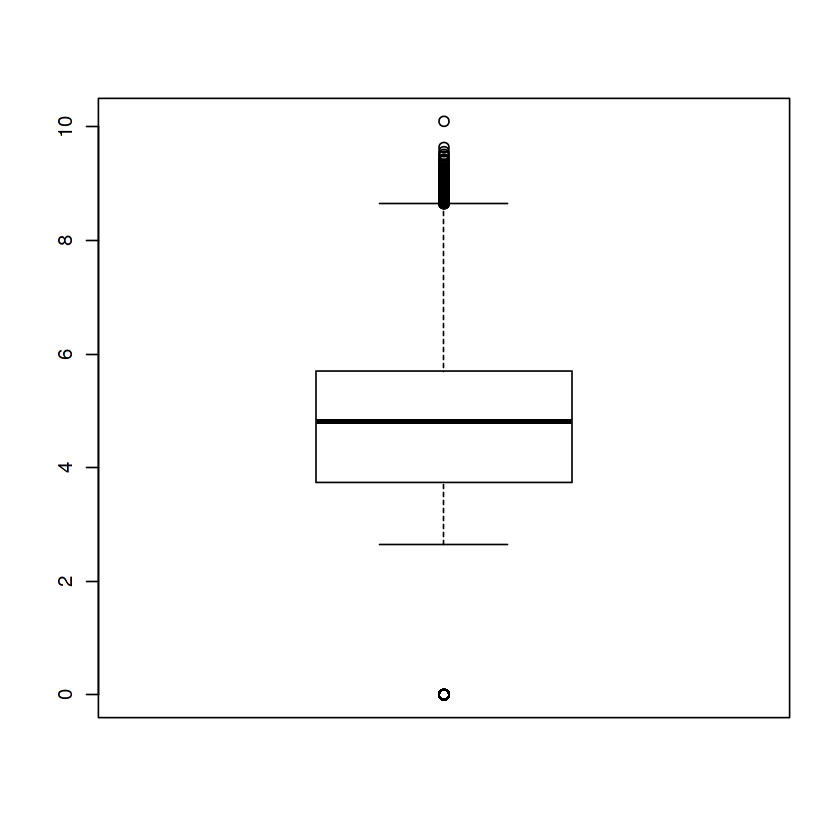

In [8]:
boxplot(log1p(data$num_orders))
data$num_orders = log1p(data$num_orders)

In [9]:
data$checkout_price = scale(data$checkout_price)
data$base_price = scale(data$base_price)

In [10]:
data$emailer_for_promotion = as.factor(data$emailer_for_promotion)
data$homepage_featured = as.factor(data$homepage_featured)

In [11]:
str(data)

'data.frame':	489121 obs. of  13 variables:
 $ id                   : int  1393410 1295523 1174971 1255368 1129188 1225174 1421626 1039159 1188064 1050666 ...
 $ week                 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ checkout_price       : num [1:489121, 1] -0.9706 0.0371 -0.0645 -0.3369 0.6076 ...
  ..- attr(*, "scaled:center")= num 333
  ..- attr(*, "scaled:scale")= num 153
 $ base_price           : num [1:489121, 1] -1.06 0.464 0.18 -0.461 0.452 ...
  ..- attr(*, "scaled:center")= num 354
  ..- attr(*, "scaled:scale")= num 160
 $ emailer_for_promotion: Factor w/ 2 levels "0","1": 1 1 1 1 1 2 1 1 1 1 ...
 $ homepage_featured    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ num_orders           : num  6.61 5.7 5.78 5.31 7.26 ...
 $ category             : Factor w/ 14 levels "Beverages","Biryani",..: 1 1 1 14 9 8 4 1 1 7 ...
 $ cuisine              : Factor w/ 4 levels "Continental",..: 3 2 1 4 2 1 4 1 2 3 ...
 $ city_code            : int  590 590 590 590 590 590 590 590 59

# Segregation train and test dat

In [12]:
train_ = data[1:nrow(train),]
test_ = data[(nrow(train) + 1):nrow(data),]

# Seperating train into train and validation set

In [13]:
train_set = train_[train$week <= 140,]
val_set = train_[train_$week > 140, ]

# One Hot Encoding
X = model.matrix(num_orders ~ .-week-id, data = train_set)[,-1]
X_val = model.matrix(num_orders ~ .-week-id, data = val_set)[,-1]

# Normal Linear Regression

In [14]:
lm.fit = lm(num_orders ~ .-week-id, data = train_set)
summary(lm.fit)
pred_lm = predict(lm.fit, newx = X_val)
sqrt(mean((val_set$num_orders - pred_lm)^2))


Call:
lm(formula = num_orders ~ . - week - id, data = train_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9658 -0.4455  0.0460  0.4888  3.6549 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.747e+00  1.119e-02  334.97   <2e-16 ***
checkout_price         -5.913e-01  4.353e-03 -135.82   <2e-16 ***
base_price              2.154e-01  5.305e-03   40.60   <2e-16 ***
emailer_for_promotion1  4.013e-01  4.886e-03   82.12   <2e-16 ***
homepage_featured1      5.297e-01  3.834e-03  138.13   <2e-16 ***
categoryBiryani        -9.795e-02  8.680e-03  -11.28   <2e-16 ***
categoryDesert          4.551e-01  8.283e-03   54.95   <2e-16 ***
categoryExtras         -4.355e-01  7.595e-03  -57.35   <2e-16 ***
categoryFish           -2.709e-01  9.828e-03  -27.57   <2e-16 ***
categoryOther Snacks   -9.532e-01  6.643e-03 -143.49   <2e-16 ***
categoryPasta          -1.557e+00  8.021e-03 -194.09   <2e-16 ***
categoryPizza           5.120e-01

Warning message in val_set$num_orders - pred_lm:
“longer object length is not a multiple of shorter object length”


[1] 1.517424

# Subsetting

In [15]:
nvmax_ = 10

subset.fit = regsubsets(num_orders ~ .-week-id, data = train_set, method='backward', nvmax = nvmax_)
k = summary(subset.fit)
k$adjr2

[1] 0.07814339 0.22866296 0.36110078 0.41088164 0.45862569 0.51492041
 [7] 0.56216101 0.58806940 0.60892162 0.61925354

In [16]:
val.errors = rep(NA, nvmax_)
for(i in 1:nvmax_){
  coefi = coef(subset.fit, id=i)
  pred = cbind(1, X_val[,names(coefi[-c(1)])]) %*% coefi
  val.errors[i]= sqrt(mean((val_set$num_orders - pred) ^2))
}
val.errors

[1] 1.1186505 1.0297900 0.9625000 0.9194502 0.8951752 0.8384202 0.7929925
 [8] 0.7498833 0.7460784 0.7387020

In [17]:
val.errors[which.min(val.errors)]

[1] 0.738702

# Lasso Regression

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


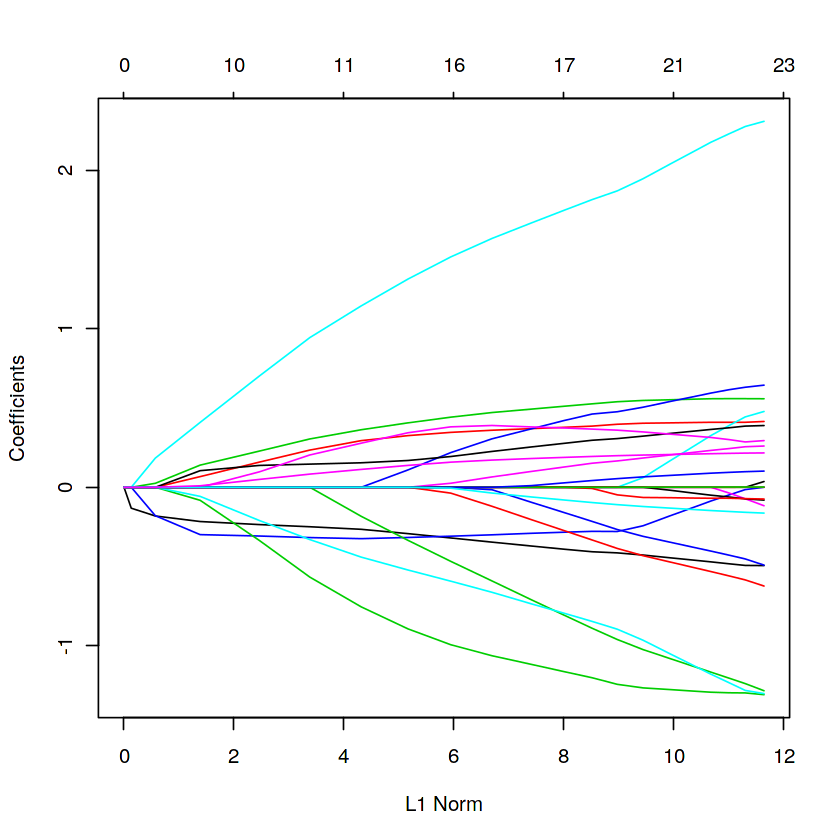

In [18]:
ld = 10^seq(10, -2, length=150)

y = train_set$num_orders
rig.fit = glmnet(X, y, alpha=1, lambda=ld)
plot(rig.fit)

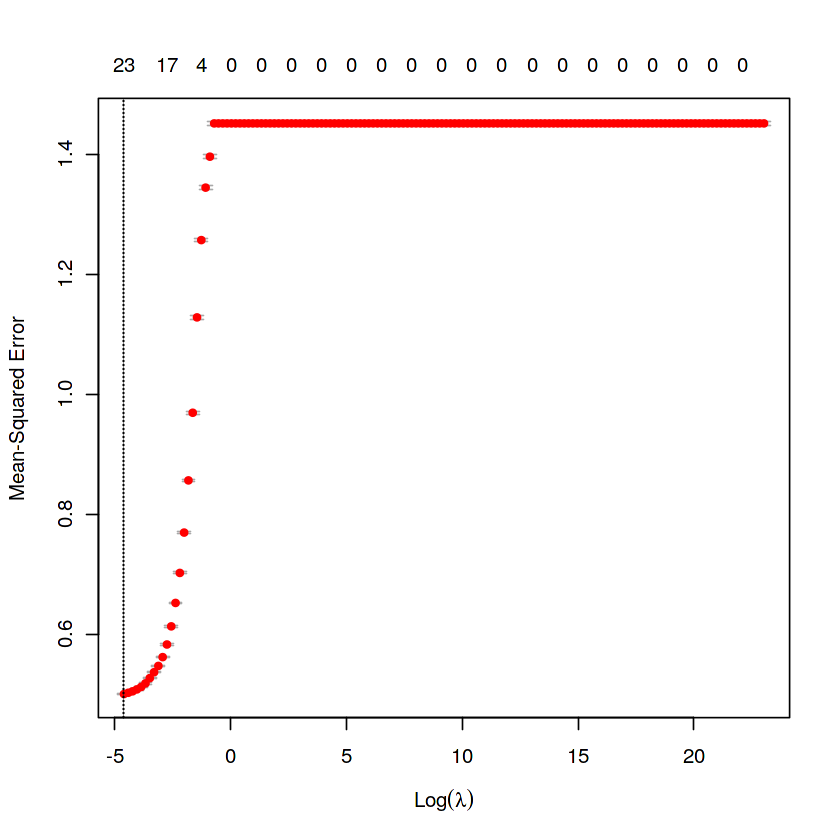

In [19]:
cvglm = cv.glmnet(X, y, alpha=1, lambda=ld, nfolds=10)
plot(cvglm)

In [20]:
best = cvglm$lambda.min
best

[1] 0.01

In [21]:
predict(rig.fit, s=best, type='coefficients')

26 x 1 sparse Matrix of class "dgCMatrix"
                                   1
(Intercept)             3.9361136057
checkout_price         -0.4941837004
base_price              .           
emailer_for_promotion1  0.4151791154
homepage_featured1      0.5585470004
categoryBiryani         .           
categoryDesert          0.4782182226
categoryExtras         -0.1165255358
categoryFish           -0.0809465095
categoryOther Snacks   -0.6232702686
categoryPasta          -1.3086784865
categoryPizza           0.6442992808
categoryRice Bowl       2.3090497139
categorySalad           0.2602373318
categorySandwich        0.3895318467
categorySeafood        -0.0741595863
categorySoup           -1.2839009475
categoryStarters       -0.4913136796
cuisineIndian          -1.3018732712
cuisineItalian          0.2944585570
cuisineThai             0.0362397431
city_code               0.0000494368
region_code             0.0016549232
center_typeTYPE_B       0.1020236942
center_typeTYPE_C      -0.1629639

In [22]:
pred_rl = predict(rig.fit, s=best, newx = X_val)
sqrt(mean((val_set$num_orders - pred_rl)^2))

[1] 0.7015941

In [23]:
# Predicting Test Set

test_set = model.matrix(num_orders ~ .-week-id, data = test_)[,-1]
pred_test = predict(rig.fit, s=best, newx = test_set)

submission = data.frame('id'=test$id,
                        'num_orders'=exp(pred_test))
names(submission)[2] = 'num_orders'

write.csv(submission, 'RL.csv', row.names = F)